In [20]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

import pdb
from utils import *
# from models import *
from data import *

PATH = os.getcwd()
DATA_PATH = "./data".format(PATH)


In [12]:
all_ids = [j.split("/")[-1].split(".")[0] for j in glob.glob("{}/three_band/*".format(DATA_PATH))]
print("{} images overall".format(len(all_ids)))

test_df = pd.read_csv("{}/sample_submission.csv".format(DATA_PATH))
test_ids = np.unique(test_df["ImageId"])
print("{} Test images".format(len(np.unique(test_df["ImageId"]))))

DF = pd.read_csv('data/train_wkt_v4.csv')
train_ids = list(np.unique(DF["ImageId"]))
len(train_ids)

val_ids = ["6100_2_2", "6110_1_2", "6140_3_1", "6160_2_1", "6170_0_4"]
      
print("{} Train images".format(len(train_ids)-len(val_ids)))
print("{} Validation images".format(len(val_ids)))

450 images overall
429 Test images
20 Train images
5 Validation images


In [16]:
# There are only 20 training images and 5 validation images from a dataset of 450 images

In [13]:
def get_means_and_stds(ids):
    means, stds = [], []
    for id_ in tqdm(ids):
        img = M(id_, dims=12)
        means.append(np.mean(img, axis=(0,1)))
        stds.append(np.std(img, axis=(0,1)))
#     save_array("{}_12_band.bc".format(which_dataset), samples)
    return means, stds

In [14]:
means, stds = get_means_and_stds(all_ids)

100%|██████████| 450/450 [20:30<00:00,  2.68s/it]


In [22]:
np.mean(np.array(means), axis=0)
np.mean(np.array(stds), axis=0)

array([63.99271 , 51.419426, 33.771034, 59.144806, 25.715368, 33.685078,
       50.72312 , 62.862896, 62.952805, 65.08902 , 88.632935, 69.42055 ],
      dtype=float32)

In [23]:
def save_images_and_labels(ids):
    imgs, masks = [], []
    for id_ in tqdm(ids):
        img = M(id_, dims=12)
        imgs.append(img)
        for j in range(1, 11):
            mask = generate_mask_for_image_and_class((img.shape[0], img.shape[1]), id_, j)
            masks.append(mask)
    imgs = np.array(imgs)
    save_array("{}/imgs_12_band.bc".format(DATA_PATH), imgs)
    masks = np.array(masks)
    save_array("{}/masks_12_band.bc".format(DATA_PATH), masks)

save_images_and_labels(train_ids)

100%|██████████| 25/25 [01:35<00:00, 10.37s/it]


TRAINING ID 6070_2_3


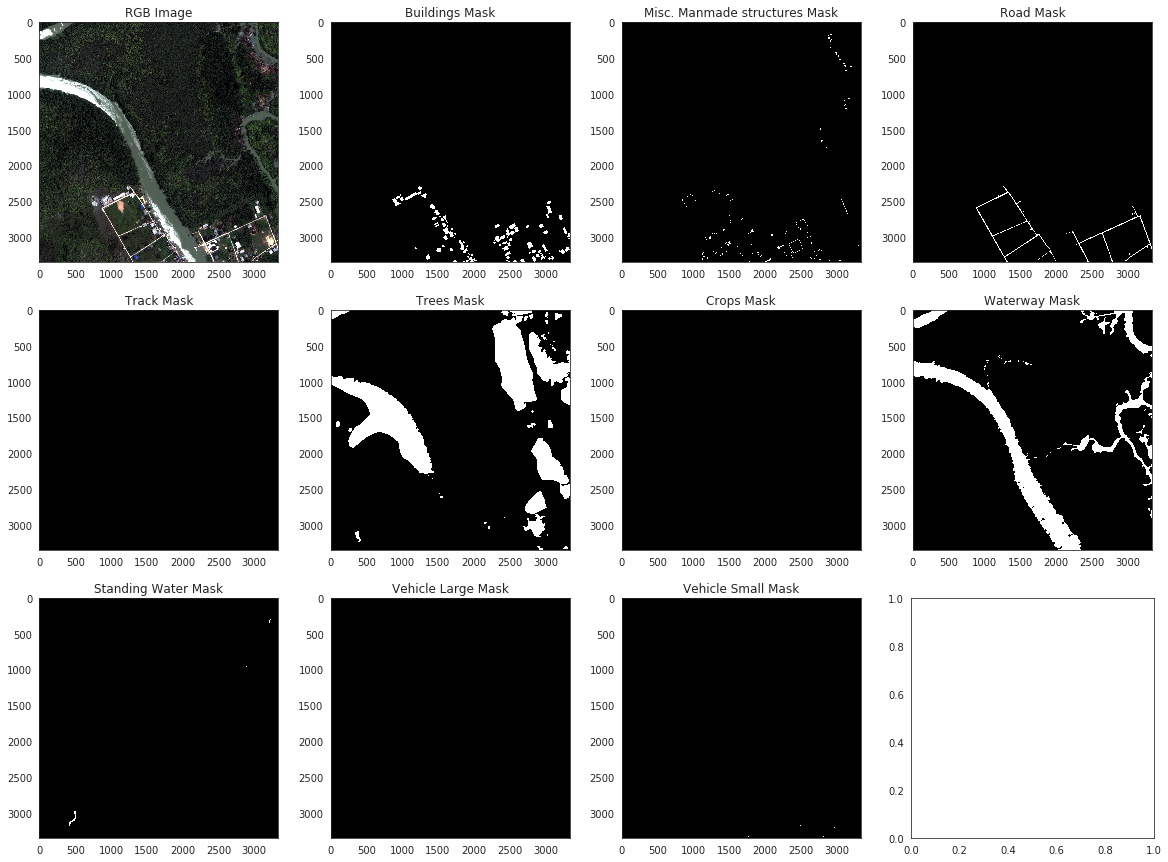

TRAINING ID 6110_1_2


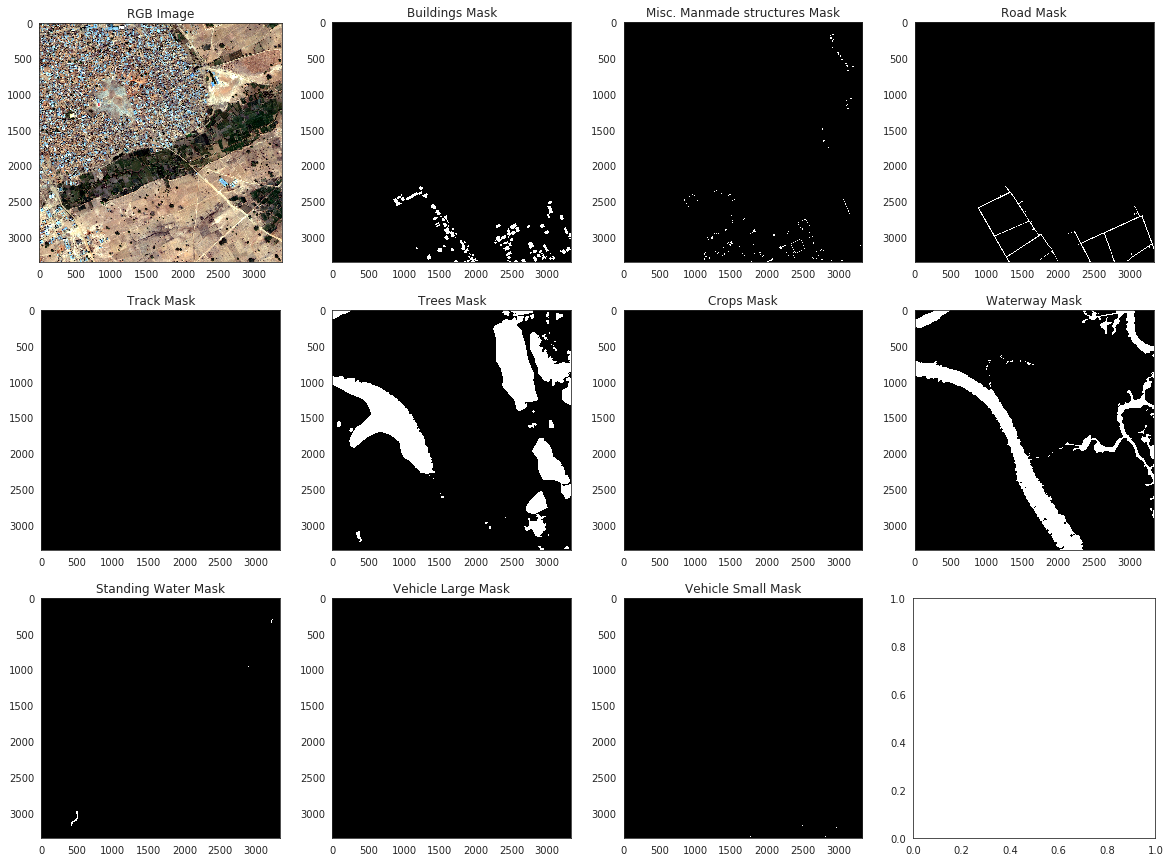

In [17]:
# let's have a look at the training data
masks = []

for id_ in ["6070_2_3", "6110_1_2"]:
    print("="*50)
    print("="*50)
    print("TRAINING ID {}".format(id_))
    print("="*50)
    print("="*50)
    img = M(id_, dims=12)
    f, axarr = plt.subplots(3, 4, figsize=(20, 15))
    for j in range(1, 11):
        mask = generate_mask_for_image_and_class((img.shape[0], img.shape[1]), id_, j)
        masks.append(mask)
    for idx, ax in enumerate(axarr.flat):
        if idx==0: 
            ax.imshow(stretch_8bit(img[:,:, :3]))
            ax.set_title("RGB Image")
        elif idx==11: 
            continue
        else: 
            ax.imshow(masks[idx-1].astype(np.uint8), cmap="gray")
            ax.set_title("{} Mask".format(class_list[idx-1]))
    plt.show()

In [24]:
# looking at some random crops for bldng images

rand_idx = random.randint(0, 24)
imgs = [bcolz.open("{}/imgs_12_band.bc".format(DATA_PATH), mode="r")[rand_idx]]
masks = [bcolz.open("{}/masks_12_band.bc".format(DATA_PATH), mode="r")[rand_idx*10]]

In [29]:
trn_dataset = DatasetDSTL([train_ids[rand_idx]], imgs=imgs, masks=masks, classes =[0], oversample=0., pick_random_idx=True, samples_per_epoch=100, which_dataset="tutorial", 
                              transform=transforms.Compose([RandomNumpyCrop(320), OwnToTensor()]))
train_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True, sampler=None)

In [30]:
def rotated(patch, angle):
    size = patch.shape[:2]
    center = tuple(np.array(size) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    patch = cv2.warpAffine(patch, rot_mat, size, flags=cv2.INTER_LINEAR)
    return patch

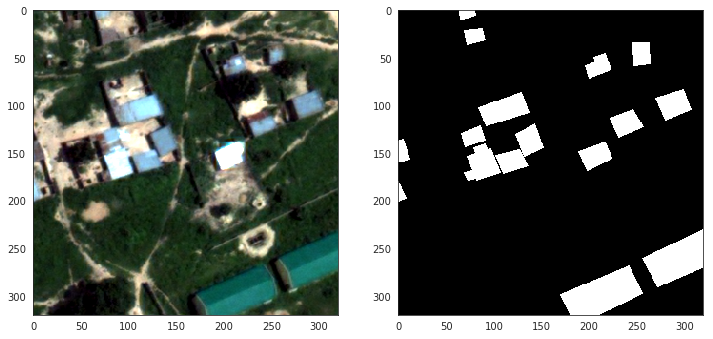

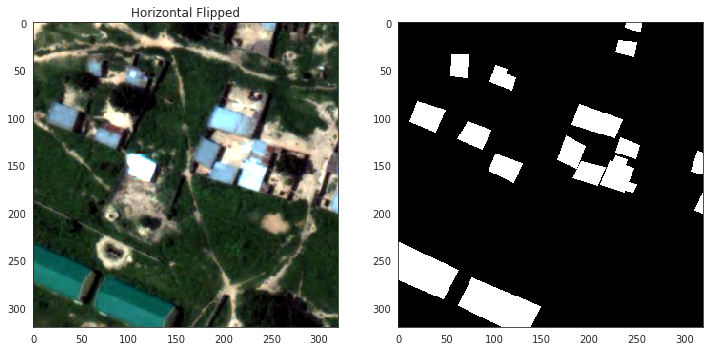

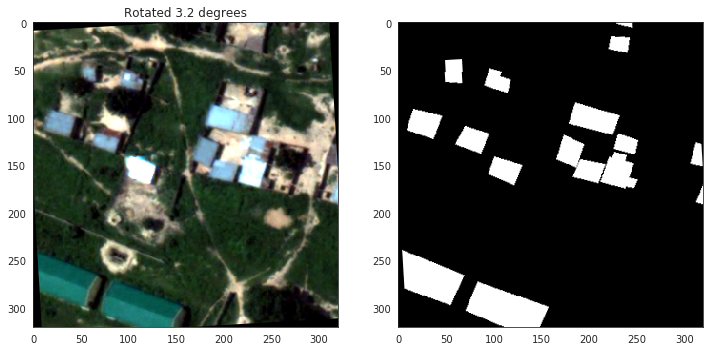

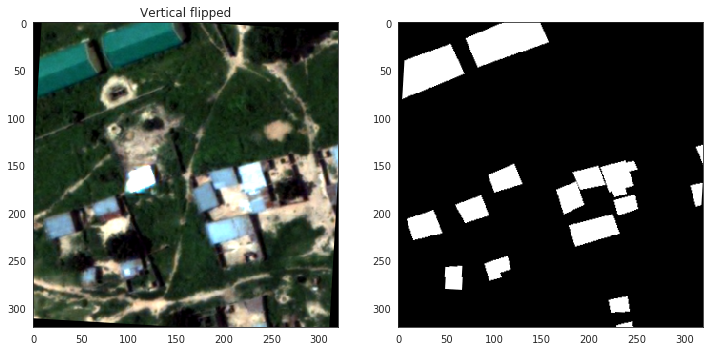

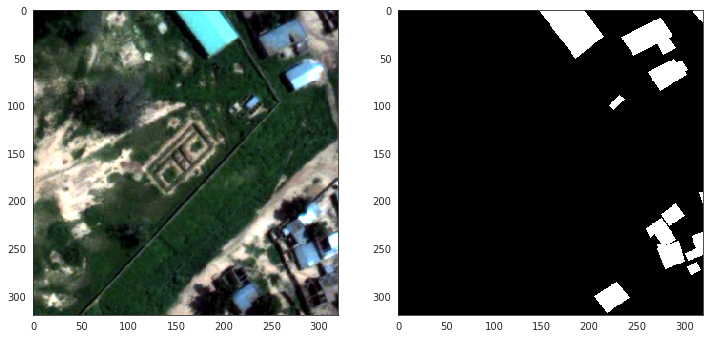

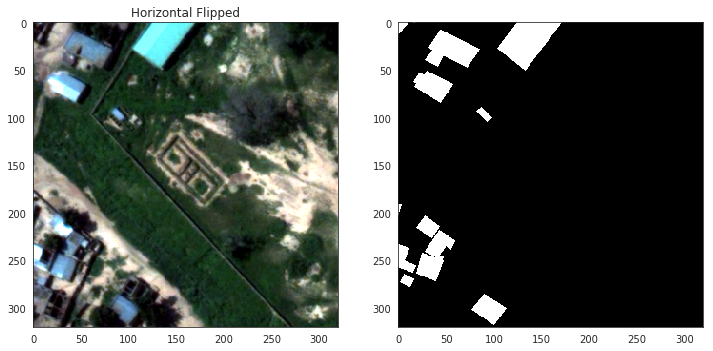

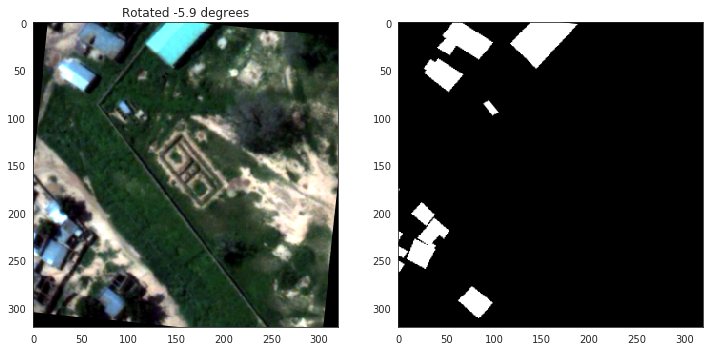

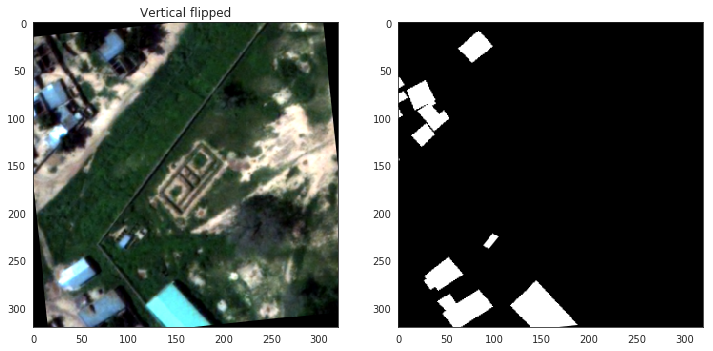

In [31]:
random_crop = RandomNumpyCrop(320)
random_rotation = RandomNumpyRotate(augment_rotations=50)

for j in range(5):
    sample = random_crop({"image": imgs[0], "mask": masks[0]})
    img, mask = sample["image"], sample["mask"]
    if mask.sum()>0:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        img = img[:, :, :3]
        img = stretch_8bit(img)
        ax1.imshow(img)
        mask = mask*255
        ax2.imshow(mask.astype(np.uint8), cmap="gray")
        plt.show()
        
        img = img[:, ::-1]
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        ax1.imshow(img)
        ax1.set_title("Horizontal Flipped")
        mask = mask[:, ::-1]
        ax2.imshow(mask.astype(np.uint8), cmap="gray")
        plt.show()
        
        angle = (2 * random.random() - 1.) * 20
        img = rotated(img, angle)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        ax1.imshow(img)
        ax1.set_title("Rotated {:.1f} degrees".format(angle))
        mask = rotated(mask, angle)
        ax2.imshow(mask.astype(np.uint8), cmap="gray")
        plt.show()
        
        img = img[::-1]
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        ax1.imshow(img)
        ax1.set_title("Vertical flipped")
        mask = mask[::-1]
        ax2.imshow(mask.astype(np.uint8), cmap="gray")
        plt.show()